In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import skew,kurtosis
import pandas as pd

In [2]:
batch1 = pickle.load(open(r'batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open(r'batch2.pkl','rb'))

In [5]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [6]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [7]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [12]:
numBat2 = len(batch2.keys())
numBat2

43

In [10]:
batch3 = pickle.load(open(r'batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

In [11]:
numBat3 = len(batch3.keys())
numBat3

40

In [13]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [14]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

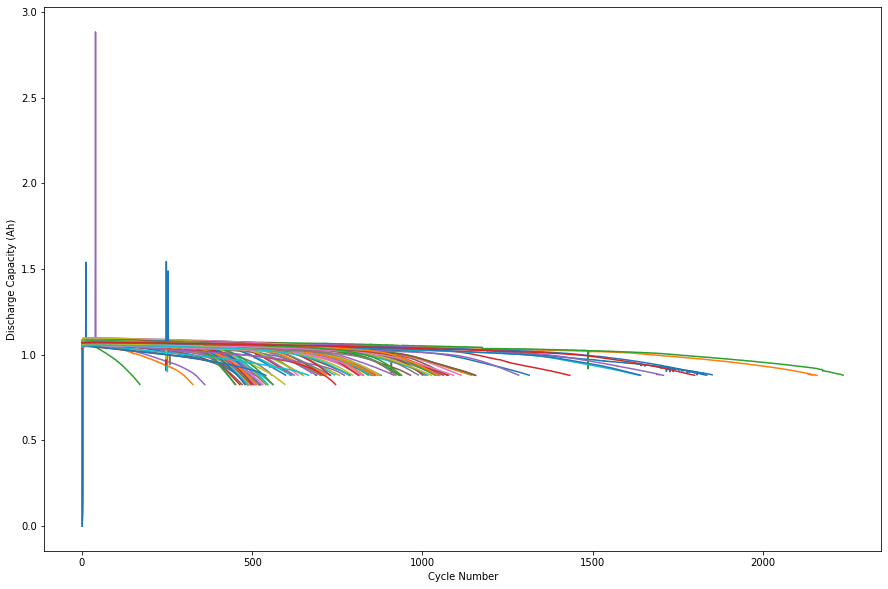

In [15]:
plt.figure(figsize=(15,10))
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [16]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

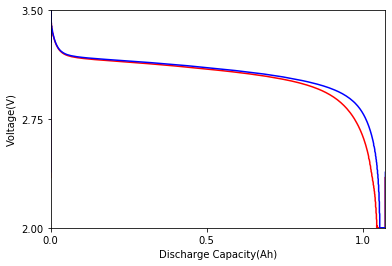

In [17]:
#Discharge capacity curves for the 100th and 10th cell for one randomly chosen cell

plt.plot(bat_dict['b2c5']['cycles']['100']['Qd'],bat_dict['b2c5']['cycles']['100']['V'],c='red')
plt.plot(bat_dict['b2c5']['cycles']['10']['Qd'],bat_dict['b2c5']['cycles']['10']['V'],c='blue')
plt.xlim((0,bat_dict['b2c5']['cycles']['10']['Qd'].max()))
plt.ylim((2,3.5))
plt.xticks(ticks=[0,0.5,1.0])
plt.yticks(ticks=[2.0,(2.0+3.5)/2,3.5])
plt.xlabel('Discharge Capacity(Ah)')
plt.ylabel('Voltage(V)')
plt.show()

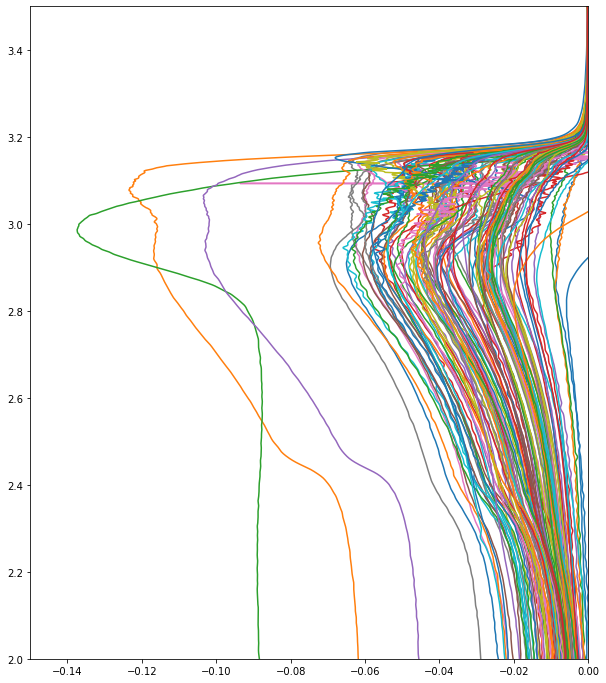

In [18]:
plt.figure(figsize=(10,12))
plt.xlim(-0.15,0)
plt.ylim(2,3.5)

minimum_dQ_100_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_100_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_100_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_100_10 = np.zeros(len(bat_dict.keys()))

for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    plt.plot(dQ_100_10,np.linspace(3.5,2,1000))
    
    minimum_dQ_100_10[i] = np.log10(np.abs(np.min(dQ_100_10)))
    variance_dQ_100_10[i] = np.log10(np.var(dQ_100_10))
    skewness_dQ_100_10[i] = np.log10(np.abs(skew(dQ_100_10)))
    kurtosis_dQ_100_10[i] = np.log10(np.abs(kurtosis(dQ_100_10)))

In [19]:
dataset=pd.DataFrame()

In [20]:
dataset['cell']=bat_dict.keys()

In [21]:
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset['cell_life']=cl

In [22]:
dataset['minimum_dQ_100_10']=minimum_dQ_100_10
dataset['variance_dQ_100_10']=variance_dQ_100_10 
dataset['skewness_dQ_100_10']=skewness_dQ_100_10 
dataset['kurtosis_dQ_100_10']=kurtosis_dQ_100_10 

In [23]:
dataset.head()

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10
0,b1c0,1852.0,-2.050261,-5.051527,-0.138643,-0.040960
1,b1c1,2160.0,-2.045150,-5.135776,-0.499000,0.016426
2,b1c2,2237.0,-1.986994,-4.951883,-0.359039,0.069572
3,b1c3,1434.0,-1.703321,-4.386348,-0.322093,0.050851
4,b1c4,1709.0,-1.837397,-4.604779,-0.456945,0.133910


In [24]:
dataset.corr()

,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10
cell_life,1.000000,-0.870445,-0.894116,0.260907,0.020858
minimum_dQ_100_10,-0.870445,1.000000,0.944222,-0.223964,0.031465
variance_dQ_100_10,-0.894116,0.944222,1.000000,-0.241558,-0.044651
skewness_dQ_100_10,0.260907,-0.223964,-0.241558,1.000000,-0.052942
kurtosis_dQ_100_10,0.020858,0.031465,-0.044651,-0.052942,1.000000


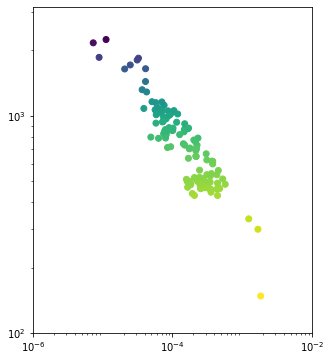

In [25]:
plt.figure(figsize=(5,6))
plt.ylim(pow(10,2),pow(10,3.5))
plt.xlim(pow(10,-6),pow(10,-2))
plt.yscale(value='log')
plt.xscale(value='log')
plt.xticks(np.power(10,np.linspace(-6,-2,3)))
plt.scatter(x=10**(dataset['variance_dQ_100_10']),y=dataset['cell_life'],cmap='viridis_r',c=dataset['cell_life'])

In [26]:
from sklearn.linear_model import LinearRegression

Slope_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
#Discharge Capacity Fade Curve Features
for i, cell in enumerate(bat_dict.values()):
    cap=cell['summary']['QD'][1:100].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:100].reshape(-1,1)
    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    
    Slope_Cap_Fade_2_100[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_100[i]=regressor.intercept_
    Discharge_Cap_2[i]=cap[1][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[1][0]
    
dataset['Slope_Cap_Fade_2_100']=Slope_Cap_Fade_2_100
dataset['Intercept_Cap_Fade_2_100']=Intercept_Cap_Fade_2_100
dataset['Discharge_Cap_2']=Discharge_Cap_2
dataset['Diff_MaxCap_DC2']=Diff_MaxCap_DC2

In [27]:
dataset.head()

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Discharge_Cap_2,Diff_MaxCap_DC2
0,b1c0,1852.0,-2.050261,-5.051527,-0.138643,-0.040960,-0.000207,1.091144,1.071900,0.467154
1,b1c1,2160.0,-2.045150,-5.135776,-0.499000,0.016426,0.000006,1.080965,1.076612,0.007977
2,b1c2,2237.0,-1.986994,-4.951883,-0.359039,0.069572,0.000010,1.084846,1.081315,0.006738
3,b1c3,1434.0,-1.703321,-4.386348,-0.322093,0.050851,0.000017,1.084075,1.081228,0.005025
4,b1c4,1709.0,-1.837397,-4.604779,-0.456945,0.133910,0.000019,1.081875,1.079012,0.005304


In [28]:
#Other features
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_100=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_100=np.zeros(len(bat_dict.keys()))

for i, cell in enumerate(bat_dict.values()):
    avg_time=np.mean(cell['summary']['chargetime'][1:6])
    a=cell['summary']['chargetime'][1:100]
    b=cell['summary']['Tavg'][1:100]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:100]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][99]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_100[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_100[i]=IR_diff

dataset['Avg_charge_time']=Avg_charge_time
dataset['Temp_Integ_2_100']=Temp_Integ_2_100
dataset['Min_IR']=Min_IR
dataset['Diff_IR_2_100']=Diff_IR_2_100 

In [29]:
dataset.head()

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Discharge_Cap_2,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,1852.0,-2.050261,-5.051527,-0.138643,-0.040960,-0.000207,1.091144,1.071900,0.467154,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,2160.0,-2.045150,-5.135776,-0.499000,0.016426,0.000006,1.080965,1.076612,0.007977,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,2237.0,-1.986994,-4.951883,-0.359039,0.069572,0.000010,1.084846,1.081315,0.006738,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,1434.0,-1.703321,-4.386348,-0.322093,0.050851,0.000017,1.084075,1.081228,0.005025,12.025140,35729.237342,0.016098,0.000039
4,b1c4,1709.0,-1.837397,-4.604779,-0.456945,0.133910,0.000019,1.081875,1.079012,0.005304,12.041851,37527.249169,0.016369,-0.000053


In [30]:
from scipy.stats import zscore
abs(zscore(dataset['kurtosis_dQ_100_10']))>2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False])

In [31]:
dataset

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Discharge_Cap_2,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,1852.0,-2.050261,-5.051527,-0.138643,-0.040960,-2.068070e-04,1.091144,1.071900,0.467154,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,2160.0,-2.045150,-5.135776,-0.499000,0.016426,5.535293e-06,1.080965,1.076612,0.007977,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,2237.0,-1.986994,-4.951883,-0.359039,0.069572,1.029563e-05,1.084846,1.081315,0.006738,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,1434.0,-1.703321,-4.386348,-0.322093,0.050851,1.713635e-05,1.084075,1.081228,0.005025,12.025140,35729.237342,0.016098,0.000039
4,b1c4,1709.0,-1.837397,-4.604779,-0.456945,0.133910,1.899432e-05,1.081875,1.079012,0.005304,12.041851,37527.249169,0.016369,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c41,786.0,-1.608813,-4.199350,-0.511520,0.040280,9.732245e-06,1.053878,1.051434,0.003450,10.042974,33447.610799,0.017007,-0.000173
120,b3c42,1642.0,-2.233379,-4.384951,0.281782,0.437447,1.810489e-06,1.069428,1.067686,0.002303,11.038937,36099.127665,0.015754,-0.000562
121,b3c43,1046.0,-1.699730,-4.152156,-0.477362,-0.283129,3.041014e-06,1.072729,1.070812,0.002522,10.043888,33702.801503,0.015550,-0.000145
122,b3c44,940.0,-1.584652,-4.133081,-0.665259,0.090173,4.689737e-06,1.073078,1.070332,0.003573,10.043436,33160.813144,0.015517,-0.000106


Anomalies

In [33]:
x=bat_dict['b1c18']['summary']['QD'][1::]
l=x[x!=x.max()].max()-x[0]
print(l)
dataset['Diff_MaxCap_DC2'].values[14]=l

0.003975300000000015


In [38]:
x=bat_dict['b1c0']['summary']['QD'][1::]
l=x[x!=x.max()].max()-x[0]
print(l)
dataset['Diff_MaxCap_DC2'].values[0]=l

0.00639320000000021


In [39]:
dataset.iloc[:,9:10]

,Diff_MaxCap_DC2
0,0.006393
1,0.007977
2,0.006738
3,0.005025
4,0.005304
...,...
119,0.003450
120,0.002303
121,0.002522
122,0.003573


In [106]:
#dataset['skewness_dQ_100_10'].values[0]=-0.456945

In [40]:
mx=dataset['minimum_dQ_100_10'].mean()
dataset['minimum_dQ_100_10'].values[36]=mx

In [41]:
xm=dataset['skewness_dQ_100_10'].mean()
dataset['skewness_dQ_100_10'].values[120]=xm

In [42]:
dataset

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Discharge_Cap_2,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,1852.0,-2.050261,-5.051527,-0.138643,-0.040960,-2.068070e-04,1.091144,1.071900,0.006393,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,2160.0,-2.045150,-5.135776,-0.499000,0.016426,5.535293e-06,1.080965,1.076612,0.007977,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,2237.0,-1.986994,-4.951883,-0.359039,0.069572,1.029563e-05,1.084846,1.081315,0.006738,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,1434.0,-1.703321,-4.386348,-0.322093,0.050851,1.713635e-05,1.084075,1.081228,0.005025,12.025140,35729.237342,0.016098,0.000039
4,b1c4,1709.0,-1.837397,-4.604779,-0.456945,0.133910,1.899432e-05,1.081875,1.079012,0.005304,12.041851,37527.249169,0.016369,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c41,786.0,-1.608813,-4.199350,-0.511520,0.040280,9.732245e-06,1.053878,1.051434,0.003450,10.042974,33447.610799,0.017007,-0.000173
120,b3c42,1642.0,-2.233379,-4.384951,-0.781039,0.437447,1.810489e-06,1.069428,1.067686,0.002303,11.038937,36099.127665,0.015754,-0.000562
121,b3c43,1046.0,-1.699730,-4.152156,-0.477362,-0.283129,3.041014e-06,1.072729,1.070812,0.002522,10.043888,33702.801503,0.015550,-0.000145
122,b3c44,940.0,-1.584652,-4.133081,-0.665259,0.090173,4.689737e-06,1.073078,1.070332,0.003573,10.043436,33160.813144,0.015517,-0.000106


In [43]:
dataset.to_csv('final_dataset.csv',na_rep='Unknown',float_format='%.6f',index=False)